In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from scipy import stats

# Temporal analysis of ERC-20 Transfer events

## Contract statistics

- We consider the first 15 million blocks of the Ethereum blockchain (i.e., from height 0 to 14999999).
- We focus only on the ERC-20 Transfer events and take all smart contracts triggering at least one of these events.
- We count the number of Transfer events for each contract.

In [8]:
contracts_rank = pd.read_csv('data/contracts_rank.csv')
contracts_rank['perc'] = ((contracts_rank['numTransfer'] * 100 / contracts_rank['numTransfer'].sum())).round(3)
contracts_rank

,contractId,contract,numTransfer,perc
0,0,dac17f958d2ee523a2206206994597c13d831ec7,149408698,15.537
1,1,c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,104183120,10.834
2,2,a0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,42601224,4.430
3,3,6b175474e89094c44da98b954eedeac495271d0f,14387573,1.496
4,4,514910771af9ca656af840dff83e8264ecf986ca,11388177,1.184
...,...,...,...,...
386610,386610,b477721fc8b9021168e213d4de6969b7d6c76aaf,1,0.000
386611,386611,66fdc9565072d8049aef0292148ae9daaac0c215,1,0.000
386612,386612,9e637a34b726c0c2fd936f5abee41476f29a9591,1,0.000
386613,386613,ff4d6e24124cc4ddafb6a6bf19e19a532a6d0af8,1,0.000


There are 386615 different contracts. We now print the total number of triggered Transfer events.

In [4]:
contracts_rank.numTransfer.sum()

961603795

- We take the top 100 contracts in terms of triggered Transfer events.
- We label each contract address with the name of the service (labels are scraped from etherscan.io).

In [5]:
contracts_top_100 = pd.read_excel('data/contracts_top_100.ods')
contracts_top_100

,contract_id,contract,num_transfer,perc,label,category,notes
0,0,dac17f958d2ee523a2206206994597c13d831ec7,149408698,15.537,Tether USD (USDT),defi,NaN
1,1,c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,104183120,10.834,Wrapped Ether (WETH),defi,NaN
2,2,a0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,42601224,4.430,USD Coin (USDC),defi,NaN
3,3,6b175474e89094c44da98b954eedeac495271d0f,14387573,1.496,Dai Stablecoin (DAI),defi,NaN
4,4,514910771af9ca656af840dff83e8264ecf986ca,11388177,1.184,ChainLink Token (LINK),other,decentralized oracle network
...,...,...,...,...,...,...,...
95,95,6c6ee5e31d828de241282b9606c8e98ea48526e2,885261,0.092,HoloToken (HOT),other,decentralized hosting platform
96,96,41e5560054824ea6b0732e656e3ad64e20e94e45,878794,0.091,Civic (CVC),other,blockchain-based identity verification
97,97,7c5cb1220bd293ff9cf903915732e51a71292038,873211,0.091,YottaLing (YTL),storage,YottaChain decentralized storage pool
98,98,57ab1ec28d129707052df4df418d58a2d46d5f51,870534,0.091,Synth sUSD (sUSD),defi,synthetic asset mirroring USD price


The first top 10 contracts trigger about 37\% of all Transfer events.

In [7]:
contracts_top_100.head(10).perc.sum()

37.13

## Block statistics

Let us now consider statistics for each block in the data set.

We have analyzed 15 million blocks (i.e., from height 0 to height 14999999). 

For each block we have computed the following information.

1) Number of distinct contracts triggering ERC20 Transfer events.
2) Total number of ERC20 Transfer events triggered.

Each block is also associated with its creation timestamp.

In [9]:
timestamps = pd.read_csv('data/block_timestamps_0-14999999.csv.xz', names=['blockId','timestamp'], compression='xz')
block_stats = pd.read_csv('data/block_stats_0-14999999.csv.xz', compression='xz')
block_stats = block_stats.merge(timestamps, on=['blockId'], how='left')
block_stats['timestamp'] = block_stats['timestamp'].astype('datetime64[s]')
block_stats

,blockId,numContracts,numTransfer,timestamp
0,0,0,0,1970-01-01 00:00:00
1,1,0,0,2015-07-30 15:26:28
2,2,0,0,2015-07-30 15:26:57
3,3,0,0,2015-07-30 15:27:28
4,4,0,0,2015-07-30 15:27:57
...,...,...,...,...
14999995,14999995,11,53,2022-06-21 02:27:32
14999996,14999996,30,78,2022-06-21 02:27:35
14999997,14999997,28,79,2022-06-21 02:27:51
14999998,14999998,15,24,2022-06-21 02:28:08


We now compute the distribution of the number of ERC20 Transfers among all blocks. 

The following plot shows, for each $x$, how many blocks include exactly $x$ Transfer events.

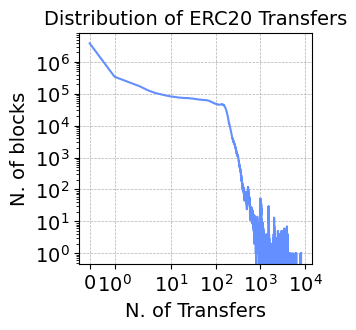

In [10]:
domain = np.arange(0, np.max(block_stats.numTransfer) + 1)
data = block_stats.numTransfer.value_counts().reindex(domain, fill_value=0)
plt.figure(figsize=(3, 3))
plt.title('Distribution of ERC20 Transfers')
plt.xlabel('N. of Transfers')
plt.ylabel('N. of blocks')
plt.xscale('symlog')
plt.yscale('log')
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.plot(data.index.values, data.values, color='#648fff')
#plt.scatter(data.index.values, data.values, color='#648fff', marker='.')
plt.grid(linestyle='--', linewidth=0.5)
plt.savefig("figures/dist_transfers.pdf", format='pdf', bbox_inches='tight')
plt.show()

The following plot shows the evolution over time of the _total_ number of Transfer events.

Each bar corresponds to a time period of one month and measures the total number of Transfer events during that month.

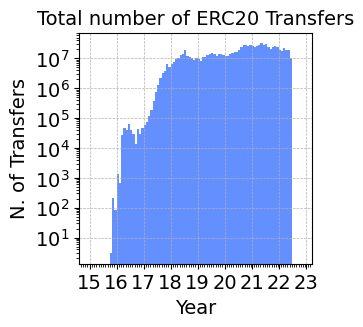

In [11]:
d1 = block_stats.timestamp.astype(int).floordiv(10**9).values
d2 = block_stats.numTransfer.values
histBins = [pd.Timestamp(y, m, 1).timestamp() for y in range(2015, 2023, 1) for m in range(1, 12+1, 1)]
plotBins = [datetime.datetime(y, m, 1) for y in range(2015, 2023, 1) for m in range(1, 12+1, 1)]
s = stats.binned_statistic(d1, d2, statistic='sum', bins=histBins)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
ax.set_title('Total number of ERC20 Transfers')
ax.set_xlabel('Year')
ax.set_ylabel('N. of Transfers')
ax.set_yscale('log')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator(12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax.stairs(s.statistic[:-1], plotBins[:-1], color='#648fff', fill=True)
ax.grid(linestyle='--', linewidth=0.5)
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.savefig("figures/temporal_total_transfers.pdf", format='pdf', bbox_inches='tight')
plt.show()